#### Step 1: Item Reduction

Which survey items are actually measuring distinct, meaningful constructs vs. which ones are redundant, unclear or not contributing much?

We want to keep the questions that clearly measure different underlying social constructs. We should do this for both the implicit and the explicit variables, as we hypothesize that both are driven by similar underlying psychological profiles.

Does our data require item reduction? Should we perform any theoretical selection? Filtering before our factor analysis.

We might firstly check the Kaiser-Meyer-Olkin (KMR) measure of sampling adequacy. This is essentially of measure of how correlated our variables are. We are looking for a high value close to 1 which indicates high correlation between related variables, but not too much multicollinearity, and an effective sample size.  

In [1]:
# KMO Analysis
import pandas as pd
from factor_analyzer import calculate_kmo

data = pd.read_pickle("../data/survey_data_cleaned.pkl")

def get_kmo(variables, name):
    df_clean = data[variables].dropna()
    kmo_all, kmo_model = calculate_kmo(df_clean.values.astype(float))
    print(f"{name}: KMO = {kmo_model:.3f}")
    return kmo_model

# Variable groups
emotional_vars = [col for col in data.columns if col.startswith(('es_', 'el_'))]
workplace_vars = [col for col in data.columns if col.startswith(('wfs_', 'wfl_'))]
latent_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
explicit_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]

# Calculate KMO
print("KMO Results:")
get_kmo(emotional_vars, "Emotional")
get_kmo(workplace_vars, "Workplace") 
get_kmo(latent_vars, "Latent (Fast Choice)")
get_kmo(explicit_vars, "Explicit (Likert)")

KMO Results:
Emotional: KMO = 0.944
Workplace: KMO = 0.880
Latent (Fast Choice): KMO = 0.911
Explicit (Likert): KMO = 0.942


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


np.float64(0.9423894439660425)

Given these fairly excellent KMO results, we don't want to reduce our items at all, as this may reduce meaningful information provide by our excellent survey results. Hence, we're ready for factor analysis.

#### Step 2: Extraction of Factors

Here we'll select factor variables, standardize our data, apply kaiser criterion, create scree plots and extract final factors.

But firstly, we should just look at what the data can tell us. 

Let's look at the correlation matrix for our two categories of responses: fast-choice and likert. 

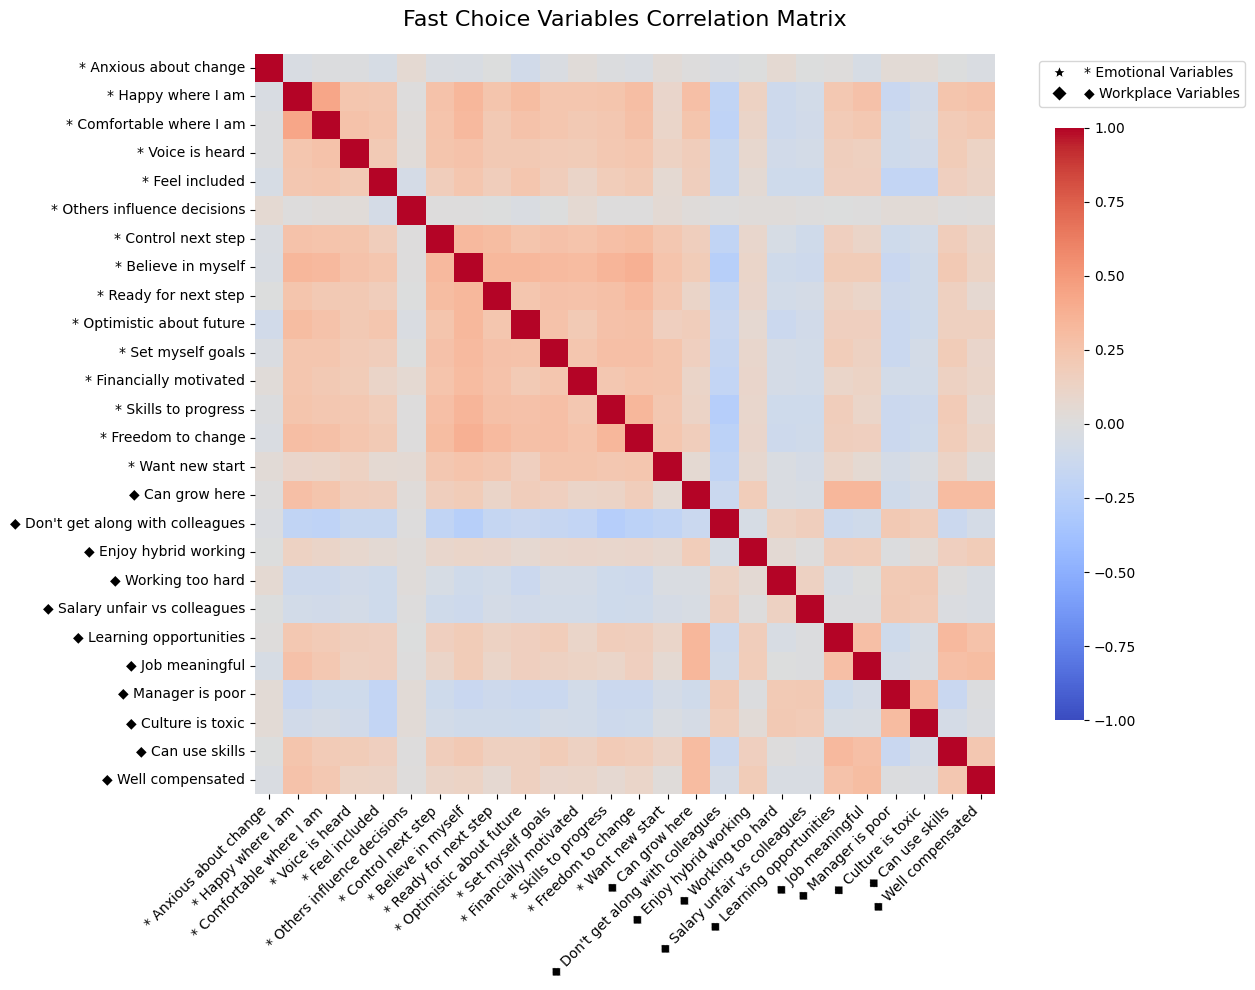

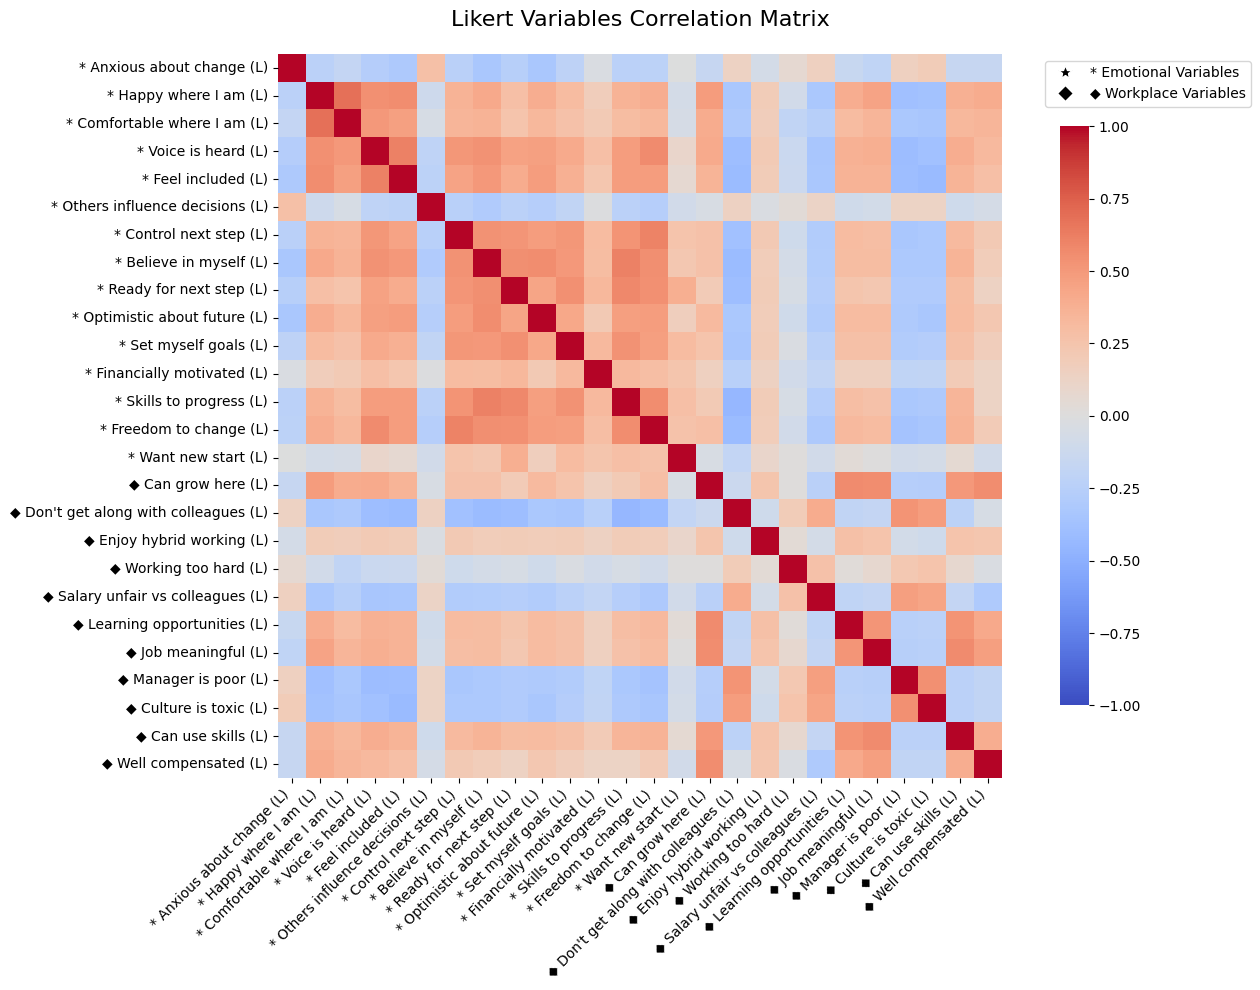

In [2]:
# Create informative variable name mappings from codebook with symbols
emotional_names = {
    'es_fgen': '* Ready for next step',
    'es_ftra_des': '* Want new start', 
    'es_ftra_aut': '* Freedom to change',
    'es_fcnt_com': '* Comfortable where I am',
    'es_fcnt_psy': '* Voice is heard',
    'es_fcon_soc': '* Others influence decisions',
    'es_fbal_anx': '* Anxious about change',
    'es_fres_fin': '* Financially motivated',
    'es_fcont_imp': '* Believe in myself',
    'es_fjou_opt': '* Optimistic about future',
    'es_fcon_inc': '* Feel included',
    'es_fbal_sat': '* Happy where I am',
    'es_fres_ski': '* Skills to progress',
    'es_fcont_con': '* Control next step',
    'es_fjou_pro': '* Set myself goals',
    'el_lgen': '* Ready for next step (L)',
    'el_ltra_des': '* Want new start (L)',
    'el_ltra_aut': '* Freedom to change (L)', 
    'el_lcnt_com': '* Comfortable where I am (L)',
    'el_lcnt_psy': '* Voice is heard (L)',
    'el_lcon_soc': '* Others influence decisions (L)',
    'el_lbal_anx': '* Anxious about change (L)',
    'el_lres_fin': '* Financially motivated (L)',
    'el_lcont_imp': '* Believe in myself (L)',
    'el_ljou_opt': '* Optimistic about future (L)',
    'el_lcon_inc': '* Feel included (L)',
    'el_lbal_sat': '* Happy where I am (L)',
    'el_lres_ski': '* Skills to progress (L)',
    'el_lcont_con': '* Control next step (L)',
    'el_ljou_pro': '* Set myself goals (L)'
}

workplace_names = {
    'wfs_fuse_skills': '◆ Can use skills',
    'wfs_flearn_dev': '◆ Learning opportunities',
    'wfs_fcarprom': '◆ Can grow here',
    'wfs_fmean_full': '◆ Job meaningful',
    'wfs_fpoorman': '◆ Manager is poor',
    'wfs_ftoxic': '◆ Culture is toxic',
    'wfs_fexcess_wk': '◆ Working too hard',
    'wfs_fcollea': '◆ Don\'t get along with colleagues',
    'wfs_fwellcomp': '◆ Well compensated',
    'wfs_ffin_fair': '◆ Salary unfair vs colleagues',
    'wfs_fenjhyb': '◆ Enjoy hybrid working',
    'wfl_luse_skills': '◆ Can use skills (L)',
    'wfl_llearn_dev': '◆ Learning opportunities (L)',
    'wfl_lcarprom_d': '◆ Can grow here (L)',
    'wfl_lmean_full': '◆ Job meaningful (L)',
    'wfl_lpoorman': '◆ Manager is poor (L)',
    'wfl_ltoxic': '◆ Culture is toxic (L)',
    'wfl_lexcess_wk': '◆ Working too hard (L)',
    'wfl_lcollea': '◆ Don\'t get along with colleagues (L)',
    'wfl_lwellcomp': '◆ Well compensated (L)',
    'wfl_lfin_lair': '◆ Salary unfair vs colleagues (L)',
    'wfl_lenjhyb': '◆ Enjoy hybrid working (L)'
}

# Get variable lists
fast_choice_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
likert_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]

# Calculate correlations
fast_choice_corr = data[fast_choice_vars].corr()
likert_corr = data[likert_vars].corr()

# Create combined name mapping
all_names = {**emotional_names, **workplace_names}

# Rename correlation matrix indices and columns
fast_choice_corr_renamed = fast_choice_corr.rename(index=all_names, columns=all_names)
likert_corr_renamed = likert_corr.rename(index=all_names, columns=all_names)

import seaborn as sns
import matplotlib.pyplot as plt

# Create color coding for variable types
def add_variable_type_colors(ax, var_names, var_list):
    """Add colored bars to distinguish emotional vs workplace variables"""
    colors = []
    for var in var_list:
        if var.startswith(('es_', 'el_')):
            colors.append('#FF6B6B')  # Red for emotional
        else:
            colors.append('#4ECDC4')  # Teal for workplace
    
    # Add colored bar on left side
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((-0.1, i), 0.1, 1, color=color, clip_on=False))
    
    # Add colored bar on bottom
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, -0.1), 1, 0.1, color=color, clip_on=False))

# Fast choice correlation matrix
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(fast_choice_corr_renamed, annot=False, cmap="coolwarm", square=True, 
           cbar_kws={"shrink": .8}, vmin=-1, vmax=1, ax=ax)
ax.set_title("Fast Choice Variables Correlation Matrix", fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', 
                             markersize=10, label='* Emotional Variables'),
                  plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='black', 
                            markersize=8, label='◆ Workplace Variables')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Likert correlation matrix  
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(likert_corr_renamed, annot=False, cmap="coolwarm", square=True,
           cbar_kws={"shrink": .8}, vmin=-1, vmax=1, ax=ax)
ax.set_title("Likert Variables Correlation Matrix", fontsize=16, pad=20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', 
                             markersize=10, label='* Emotional Variables'),
                  plt.Line2D([0], [0], marker='D', color='w', markerfacecolor='black', 
                            markersize=8, label='◆ Workplace Variables')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

Immediately we can see some very clear patterns.

Fast Choice Vars:
- Correlations are not as strong comparatively
- Covariance among subset of emotional variables, specifically those related to believing in one's self and future planning
- Some very logical correlations, between 'can grow here' and 'learning opportunities/job meaningful'
- Some clear groupings, it would make sense that there's latent factors explaining our variance
- Emotional vars tend to co-vary, as do Workplace/Functional, but covariance between the two is less common 

Likert Variables:
- Stronger correlations in general, especially within the emotional/workplace groupings
- A lot less gray, implies that likert responses are just more extreme (i.e. perhaps people are more decisive when they have time to think about their answers)

Interestingly, in both, some questions just don't correlate much at all.

What about correlations with "Ready for next step"

Fast choice:
- Positive: Believe in myself, In control of next step, freedom to change etc.
- Negative: Anxious about change, others influence financial decisions, 

Likert:
- Positive: Set myself goals, freedom to change, skills to progress, can use skills
- Negative: Anxious about change, others influence decisions, don't get along with colleagues, salary unfair, manager poor/toxic 

We can really start to see why a factor analysis is beneficial for our data. There's a lot of variables and variance patterns to sort through. A manually encoding approach would probably introduce a lot of measurement error. Likewise, it's very plausible that our factor analysis would pick up a real 'latent factors'.

##### Now let's proceed onto the factor analysis.

Need to evaluate:
1) factor loading - how high the correlation between the variable and the factor
2) eigenvalue - how much variance can be explained by the factor of all variables
3) communality - how much variance of the total variables can be explained by the factors 

To do the above, we need the communalities and the factor component matrix.

Fast choice variables: 26
Likert variables: 26
FACTOR ANALYSIS

Fast Choice Variables - Sample size after removing missing: 4194
Bartlett's test: Chi-square = 16505.25, p-value = 0.0000
KMO test: 0.911


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


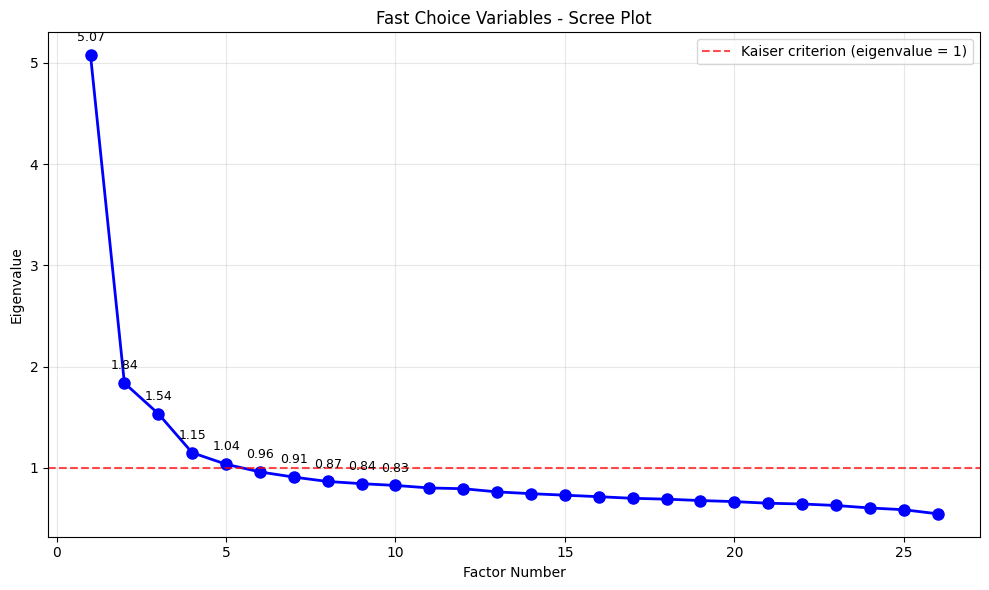

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 11
Factors explaining 70% variance: 15
First 5 factors explain: 40.9% of variance

Using 5 factors for analysis

=== Fast Choice Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 5.075 | 19.5% of total | 47.7% of extracted | 47.7% cumulative
Factor 2: 1.838 | 7.1% of total | 17.3% of extracted | 65.0% cumulative
Factor 3: 1.536 | 5.9% of total | 14.4% of extracted | 79.4% cumulative
Factor 4: 1.150 | 4.4% of total | 10.8% of extracted | 90.3% cumulative
Factor 5: 1.036 | 4.0% of total | 9.7% of extracted | 100.0% cumulative

Factor Loadings Matrix:


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


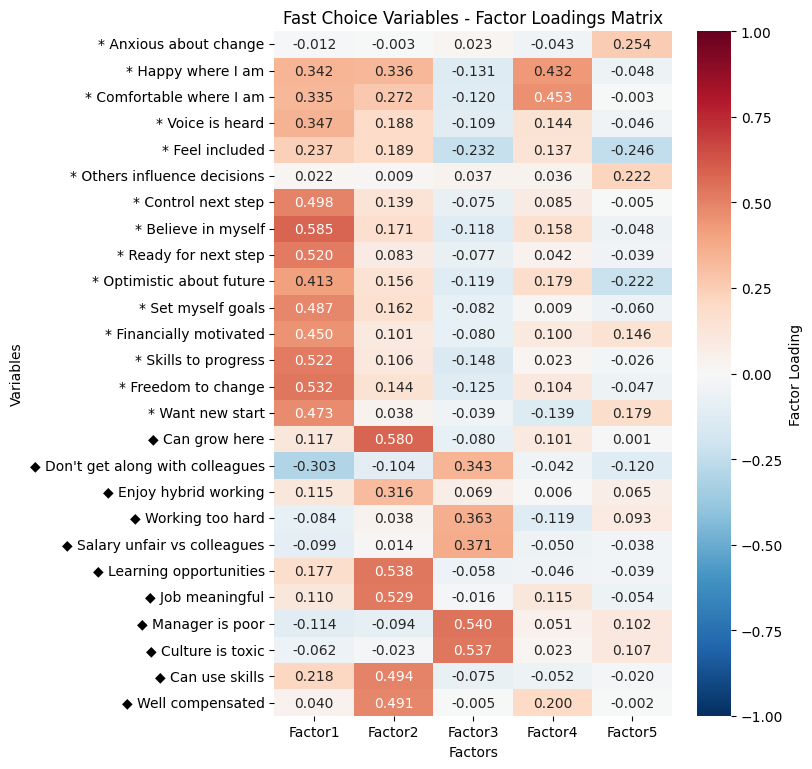


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am                     0.435
* Believe in myself                    0.413
* Comfortable where I am               0.406
◆ Can grow here                        0.366
* Freedom to change                    0.333
◆ Learning opportunities               0.327
◆ Manager is poor                      0.326
◆ Job meaningful                       0.308
* Skills to progress                   0.306
◆ Culture is toxic                     0.304
◆ Can use skills                       0.301
* Optimistic about future              0.291
* Ready for next step                  0.287
◆ Well compensated                     0.283
* Control next step                    0.280
* Want new start                       0.278
* Set myself goals                     0.274
* Financially motivated                0.250
◆ Don't get along with colleagues      0.237
* Feel included

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


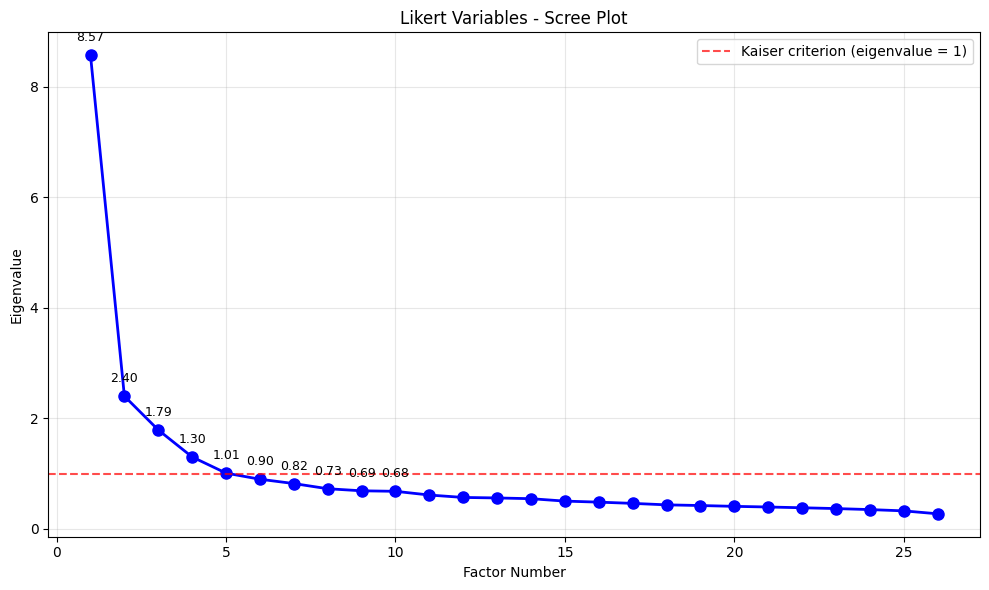

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 6
Factors explaining 70% variance: 9
First 5 factors explain: 58.0% of variance

Using 5 factors for analysis

=== Likert Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 8.570 | 33.0% of total | 56.9% of extracted | 56.9% cumulative
Factor 2: 2.402 | 9.2% of total | 15.9% of extracted | 72.8% cumulative
Factor 3: 1.790 | 6.9% of total | 11.9% of extracted | 84.7% cumulative
Factor 4: 1.302 | 5.0% of total | 8.6% of extracted | 93.3% cumulative
Factor 5: 1.010 | 3.9% of total | 6.7% of extracted | 100.0% cumulative

Factor Loadings Matrix:


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


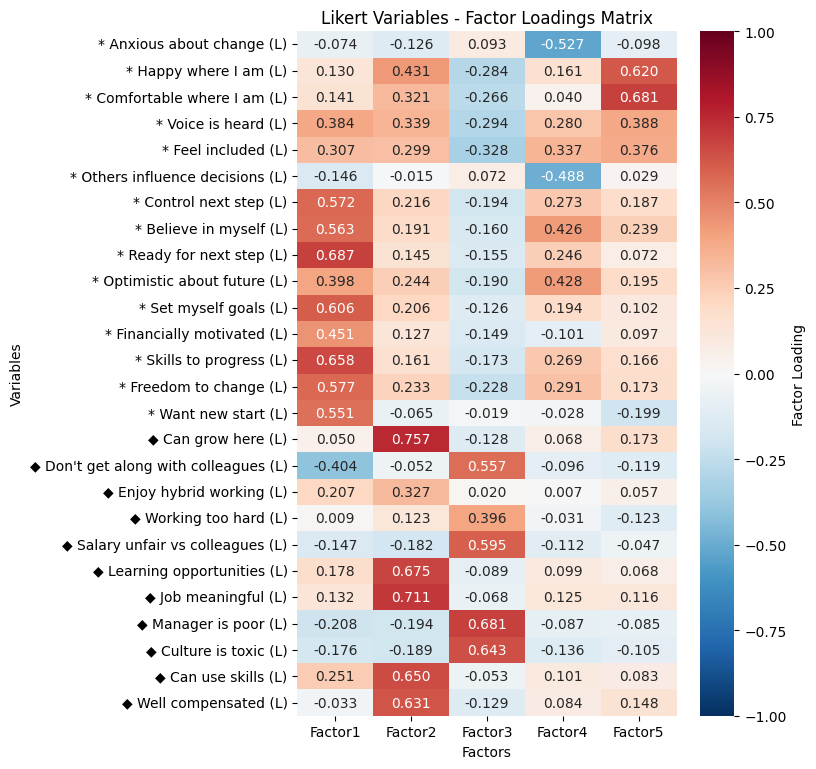


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am (L)                 0.694
* Comfortable where I am (L)           0.659
◆ Can grow here (L)                    0.627
* Believe in myself (L)                0.619
* Skills to progress (L)               0.590
* Ready for next step (L)              0.582
* Voice is heard (L)                   0.578
◆ Manager is poor (L)                  0.559
◆ Job meaningful (L)                   0.556
* Freedom to change (L)                0.553
* Feel included (L)                    0.546
* Control next step (L)                0.521
◆ Learning opportunities (L)           0.510
◆ Culture is toxic (L)                 0.509
◆ Can use skills (L)                   0.505
◆ Don't get along with colleagues...    0.500
* Optimistic about future (L)          0.475
* Set myself goals (L)                 0.474
◆ Well compensated (L)                 0.444
◆ Salary unfai

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import bartlett
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Variable name mappings from your code
emotional_names = {
    'es_fgen': '* Ready for next step',
    'es_ftra_des': '* Want new start', 
    'es_ftra_aut': '* Freedom to change',
    'es_fcnt_com': '* Comfortable where I am',
    'es_fcnt_psy': '* Voice is heard',
    'es_fcon_soc': '* Others influence decisions',
    'es_fbal_anx': '* Anxious about change',
    'es_fres_fin': '* Financially motivated',
    'es_fcont_imp': '* Believe in myself',
    'es_fjou_opt': '* Optimistic about future',
    'es_fcon_inc': '* Feel included',
    'es_fbal_sat': '* Happy where I am',
    'es_fres_ski': '* Skills to progress',
    'es_fcont_con': '* Control next step',
    'es_fjou_pro': '* Set myself goals',
    'el_lgen': '* Ready for next step (L)',
    'el_ltra_des': '* Want new start (L)',
    'el_ltra_aut': '* Freedom to change (L)', 
    'el_lcnt_com': '* Comfortable where I am (L)',
    'el_lcnt_psy': '* Voice is heard (L)',
    'el_lcon_soc': '* Others influence decisions (L)',
    'el_lbal_anx': '* Anxious about change (L)',
    'el_lres_fin': '* Financially motivated (L)',
    'el_lcont_imp': '* Believe in myself (L)',
    'el_ljou_opt': '* Optimistic about future (L)',
    'el_lcon_inc': '* Feel included (L)',
    'el_lbal_sat': '* Happy where I am (L)',
    'el_lres_ski': '* Skills to progress (L)',
    'el_lcont_con': '* Control next step (L)',
    'el_ljou_pro': '* Set myself goals (L)'
}

workplace_names = {
    'wfs_fuse_skills': '◆ Can use skills',
    'wfs_flearn_dev': '◆ Learning opportunities',
    'wfs_fcarprom': '◆ Can grow here',
    'wfs_fmean_full': '◆ Job meaningful',
    'wfs_fpoorman': '◆ Manager is poor',
    'wfs_ftoxic': '◆ Culture is toxic',
    'wfs_fexcess_wk': '◆ Working too hard',
    'wfs_fcollea': '◆ Don\'t get along with colleagues',
    'wfs_fwellcomp': '◆ Well compensated',
    'wfs_ffin_fair': '◆ Salary unfair vs colleagues',
    'wfs_fenjhyb': '◆ Enjoy hybrid working',
    'wfl_luse_skills': '◆ Can use skills (L)',
    'wfl_llearn_dev': '◆ Learning opportunities (L)',
    'wfl_lcarprom_d': '◆ Can grow here (L)',
    'wfl_lmean_full': '◆ Job meaningful (L)',
    'wfl_lpoorman': '◆ Manager is poor (L)',
    'wfl_ltoxic': '◆ Culture is toxic (L)',
    'wfl_lexcess_wk': '◆ Working too hard (L)',
    'wfl_lcollea': '◆ Don\'t get along with colleagues (L)',
    'wfl_lwellcomp': '◆ Well compensated (L)',
    'wfl_lfin_lair': '◆ Salary unfair vs colleagues (L)',
    'wfl_lenjhyb': '◆ Enjoy hybrid working (L)'
}

# Combine mappings
all_names = {**emotional_names, **workplace_names}

# Get variable lists from your existing code
fast_choice_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
likert_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]

print(f"Fast choice variables: {len(fast_choice_vars)}")
print(f"Likert variables: {len(likert_vars)}")

def perform_factor_analysis(df, var_list, title_prefix):
    """Perform factor analysis with scree plot"""
    
    # Select and clean data
    fa_data = df[var_list].dropna()
    print(f"\n{title_prefix} - Sample size after removing missing: {len(fa_data)}")
    
    # Standardize data
    scaler = StandardScaler()
    fa_data_scaled = scaler.fit_transform(fa_data)
    fa_data_scaled = pd.DataFrame(fa_data_scaled, columns=var_list)
    
    # Test assumptions
    # Bartlett's test for sphericity
    chi_square_value, p_value = calculate_bartlett_sphericity(fa_data_scaled)
    print(f"Bartlett's test: Chi-square = {chi_square_value:.2f}, p-value = {p_value:.4f}")
    
    # Kaiser-Meyer-Olkin test
    kmo_all, kmo_model = calculate_kmo(fa_data_scaled)
    print(f"KMO test: {kmo_model:.3f}")
    
    # Scree plot - determine number of factors
    fa_scree = FactorAnalyzer(n_factors=len(var_list), rotation=None)
    fa_scree.fit(fa_data_scaled)
    
    # Get eigenvalues
    eigenvalues, _ = fa_scree.get_eigenvalues()
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    factors = range(1, len(eigenvalues) + 1)
    plt.plot(factors, eigenvalues, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Kaiser criterion (eigenvalue = 1)')
    plt.title(f'{title_prefix} - Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add eigenvalue labels
    for i, ev in enumerate(eigenvalues[:10]):  # Label first 10
        plt.annotate(f'{ev:.2f}', (i+1, ev), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Determine number of factors (Kaiser criterion: eigenvalue > 1)
    n_factors = sum(eigenvalues > 1)
    print(f"Number of factors (Kaiser criterion): {n_factors}")
    
    # Alternative: explained variance criterion (e.g., 60-70%)
    cumvar = np.cumsum(eigenvalues) / sum(eigenvalues) * 100
    n_factors_60 = sum(cumvar < 60) + 1
    n_factors_70 = sum(cumvar < 70) + 1
    
    print(f"Factors explaining 60% variance: {n_factors_60}")
    print(f"Factors explaining 70% variance: {n_factors_70}")
    print(f"First 5 factors explain: {cumvar[4]:.1f}% of variance")
    
    # Perform factor analysis with determined number of factors
    n_factors_final = max(2, min(n_factors, 5))  # Use 2-5 factors
    print(f"\nUsing {n_factors_final} factors for analysis")
    
    # Factor analysis with varimax rotation
    fa = FactorAnalyzer(n_factors=n_factors_final, rotation='varimax')
    fa.fit(fa_data_scaled)
    
    # Get results with proper variable names
    loadings = pd.DataFrame(fa.loadings_, 
                           columns=[f'Factor{i+1}' for i in range(n_factors_final)],
                           index=var_list)
    
    # Add descriptive names
    loadings['Variable_Name'] = loadings.index.map(all_names)
    loadings = loadings[['Variable_Name'] + [f'Factor{i+1}' for i in range(n_factors_final)]]
    
    communalities = pd.DataFrame({'Variable_Name': [all_names.get(var, var) for var in var_list],
                                 'Communality': fa.get_communalities()}, 
                                index=var_list)
    
    eigenvalues_final = fa.get_eigenvalues()[0][:n_factors_final]
    
    # Print results
    print(f"\n=== {title_prefix} RESULTS ===")
    print(f"\nEigenvalues and Variance Explained:")
    total_variance = sum(eigenvalues_final)
    cumulative = 0
    for i, ev in enumerate(eigenvalues_final):
        var_explained = ev / len(var_list) * 100
        prop_explained = ev / total_variance * 100
        cumulative += prop_explained
        print(f"Factor {i+1}: {ev:.3f} | {var_explained:.1f}% of total | {prop_explained:.1f}% of extracted | {cumulative:.1f}% cumulative")
    
    # Factor loadings heatmap
    print(f"\nFactor Loadings Matrix:")
    
    # Prepare data for heatmap
    loadings_heatmap = loadings.copy()
    factor_cols = [f'Factor{i+1}' for i in range(n_factors_final)]
    loadings_matrix = loadings_heatmap[factor_cols]
    
    # Create heatmap
    plt.figure(figsize=(8, max(6, len(var_list) * 0.3)))
    
    # Use RdBu_r colormap (red-white-blue reversed) for better positive/negative distinction
    sns.heatmap(loadings_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r', 
                center=0,
                vmin=-1, 
                vmax=1,
                cbar_kws={'label': 'Factor Loading'},
                yticklabels=[all_names.get(var, var) for var in var_list])
    
    plt.title(f'{title_prefix} - Factor Loadings Matrix')
    plt.xlabel('Factors')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    # Communalities table
    print(f"\nCommunalities (sorted by value):")
    print("=" * 50)
    comm_sorted = communalities.sort_values('Communality', ascending=False)
    print(f"{'Variable':<35} {'Communality':>10}")
    print("-" * 47)
    for idx, row in comm_sorted.iterrows():
        var_name = row['Variable_Name'][:33] + ('...' if len(row['Variable_Name']) > 33 else '')
        comm_val = row['Communality']
        print(f"{var_name:<35} {comm_val:>8.3f}")
    
    # Low communalities warning
    low_comm = communalities[communalities['Communality'] < 0.3]
    if len(low_comm) > 0:
        print(f"\n⚠️  Variables with low communalities (< 0.3) - consider removal:")
        for idx, row in low_comm.iterrows():
            print(f"   {row['Variable_Name']}: {row['Communality']:.3f}")
    else:
        print(f"\n✅ All variables have adequate communalities (≥ 0.3)")
    
    return {
        'loadings': loadings,
        'communalities': communalities,
        'eigenvalues': eigenvalues_final,
        'factor_analyzer': fa,
        'n_factors': n_factors_final
    }

# Perform factor analysis for both groups
print("="*60)
print("FACTOR ANALYSIS")
print("="*60)

# Fast choice variables
results_fast = perform_factor_analysis(data, fast_choice_vars, "Fast Choice Variables")

# Likert variables  
results_likert = perform_factor_analysis(data, likert_vars, "Likert Variables")


##### Interpreting the factors

Factor 1: Appears to capture career agency/self-efficacy - high loadings on "Ready for next step" (0.687), "Set myself goals" (0.606), "Control next step" (0.572), "Believe in myself" (0.563)

Factor 2: Looks like workplace satisfaction/growth - strong loadings on "Can grow here" (0.757), "Job meaningful" (0.711), "Learning opportunities" (0.675), "Can use skills" (0.650)

Factor 3: Represents workplace dysfunction - high loadings on "Culture is toxic" (0.643), "Manager is poor" (0.681), "Salary unfair vs colleagues" (0.595)

Factor 4: Mixed factor, harder to interpret cleanly (probably left-over variance, non correlated variables)

Factor 5: Also mixed, potentially workplace comfort but weak loadings (probably left-over variance)

#### More refined version of the Above, adding different variations for different variable subsets

In [4]:
# Enhanced Factor Analysis with Multiple Approaches
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from scipy.stats import bartlett
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Load data
data = pd.read_pickle("../data/survey_data_cleaned.pkl")

# Variable name mappings
emotional_names = {
    'es_fgen': '* Ready for next step',
    'es_ftra_des': '* Want new start', 
    'es_ftra_aut': '* Freedom to change',
    'es_fcnt_com': '* Comfortable where I am',
    'es_fcnt_psy': '* Voice is heard',
    'es_fcon_soc': '* Others influence decisions',
    'es_fbal_anx': '* Anxious about change',
    'es_fres_fin': '* Financially motivated',
    'es_fcont_imp': '* Believe in myself',
    'es_fjou_opt': '* Optimistic about future',
    'es_fcon_inc': '* Feel included',
    'es_fbal_sat': '* Happy where I am',
    'es_fres_ski': '* Skills to progress',
    'es_fcont_con': '* Control next step',
    'es_fjou_pro': '* Set myself goals',
    'el_lgen': '* Ready for next step (L)',
    'el_ltra_des': '* Want new start (L)',
    'el_ltra_aut': '* Freedom to change (L)', 
    'el_lcnt_com': '* Comfortable where I am (L)',
    'el_lcnt_psy': '* Voice is heard (L)',
    'el_lcon_soc': '* Others influence decisions (L)',
    'el_lbal_anx': '* Anxious about change (L)',
    'el_lres_fin': '* Financially motivated (L)',
    'el_lcont_imp': '* Believe in myself (L)',
    'el_ljou_opt': '* Optimistic about future (L)',
    'el_lcon_inc': '* Feel included (L)',
    'el_lbal_sat': '* Happy where I am (L)',
    'el_lres_ski': '* Skills to progress (L)',
    'el_lcont_con': '* Control next step (L)',
    'el_ljou_pro': '* Set myself goals (L)'
}

workplace_names = {
    'wfs_fuse_skills': '◆ Can use skills',
    'wfs_flearn_dev': '◆ Learning opportunities',
    'wfs_fcarprom': '◆ Can grow here',
    'wfs_fmean_full': '◆ Job meaningful',
    'wfs_fpoorman': '◆ Manager is poor',
    'wfs_ftoxic': '◆ Culture is toxic',
    'wfs_fexcess_wk': '◆ Working too hard',
    'wfs_fcollea': '◆ Don\'t get along with colleagues',
    'wfs_fwellcomp': '◆ Well compensated',
    'wfs_ffin_fair': '◆ Salary unfair vs colleagues',
    'wfs_fenjhyb': '◆ Enjoy hybrid working',
    'wfl_luse_skills': '◆ Can use skills (L)',
    'wfl_llearn_dev': '◆ Learning opportunities (L)',
    'wfl_lcarprom_d': '◆ Can grow here (L)',
    'wfl_lmean_full': '◆ Job meaningful (L)',
    'wfl_lpoorman': '◆ Manager is poor (L)',
    'wfl_ltoxic': '◆ Culture is toxic (L)',
    'wfl_lexcess_wk': '◆ Working too hard (L)',
    'wfl_lcollea': '◆ Don\'t get along with colleagues (L)',
    'wfl_lwellcomp': '◆ Well compensated (L)',
    'wfl_lfin_lair': '◆ Salary unfair vs colleagues (L)',
    'wfl_lenjhyb': '◆ Enjoy hybrid working (L)'
}

# Combine mappings
all_names = {**emotional_names, **workplace_names}

# Define variable groups
emotional_vars = [col for col in data.columns if col.startswith(('es_', 'el_'))]
workplace_vars = [col for col in data.columns if col.startswith(('wfs_', 'wfl_'))]
fast_choice_vars = [col for col in data.columns if col.startswith(('es_', 'wfs_'))]
likert_vars = [col for col in data.columns if col.startswith(('el_', 'wfl_'))]
all_survey_vars = fast_choice_vars + likert_vars
personality_vars = [col for col in data.columns if col.startswith('pers_')]

def perform_factor_analysis(df, var_list, title_prefix):
    """Perform factor analysis with comprehensive output"""
    
    # Select and clean data
    fa_data = df[var_list].dropna()
    print(f"\n{title_prefix} - Sample size after removing missing: {len(fa_data)}")
    
    # Standardize data
    scaler = StandardScaler()
    fa_data_scaled = scaler.fit_transform(fa_data)
    fa_data_scaled = pd.DataFrame(fa_data_scaled, columns=var_list)
    
    # Test assumptions
    chi_square_value, p_value = calculate_bartlett_sphericity(fa_data_scaled)
    print(f"Bartlett's test: Chi-square = {chi_square_value:.2f}, p-value = {p_value:.4f}")
    
    kmo_all, kmo_model = calculate_kmo(fa_data_scaled)
    print(f"KMO test: {kmo_model:.3f}")
    
    # Scree plot - determine number of factors
    fa_scree = FactorAnalyzer(n_factors=len(var_list), rotation=None)
    fa_scree.fit(fa_data_scaled)
    
    eigenvalues, _ = fa_scree.get_eigenvalues()
    
    # Create scree plot
    plt.figure(figsize=(10, 6))
    factors = range(1, len(eigenvalues) + 1)
    plt.plot(factors, eigenvalues, 'bo-', linewidth=2, markersize=8)
    plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Kaiser criterion (eigenvalue = 1)')
    plt.title(f'{title_prefix} - Scree Plot')
    plt.xlabel('Factor Number')
    plt.ylabel('Eigenvalue')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Add eigenvalue labels for first 10
    for i, ev in enumerate(eigenvalues[:10]):
        plt.annotate(f'{ev:.2f}', (i+1, ev), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Determine number of factors
    n_factors = sum(eigenvalues > 1)
    print(f"Number of factors (Kaiser criterion): {n_factors}")
    
    cumvar = np.cumsum(eigenvalues) / sum(eigenvalues) * 100
    n_factors_60 = sum(cumvar < 60) + 1
    n_factors_70 = sum(cumvar < 70) + 1
    
    print(f"Factors explaining 60% variance: {n_factors_60}")
    print(f"Factors explaining 70% variance: {n_factors_70}")
    print(f"First 5 factors explain: {cumvar[4]:.1f}% of variance")
    
    # Use 2-5 factors
    n_factors_final = max(2, min(n_factors, 5))
    print(f"\nUsing {n_factors_final} factors for analysis")
    
    # Factor analysis with varimax rotation
    fa = FactorAnalyzer(n_factors=n_factors_final, rotation='varimax')
    fa.fit(fa_data_scaled)
    
    # Get results with proper variable names
    loadings = pd.DataFrame(fa.loadings_, 
                           columns=[f'Factor{i+1}' for i in range(n_factors_final)],
                           index=var_list)
    
    # Add descriptive names
    loadings['Variable_Name'] = loadings.index.map(all_names)
    loadings = loadings[['Variable_Name'] + [f'Factor{i+1}' for i in range(n_factors_final)]]
    
    communalities = pd.DataFrame({'Variable_Name': [all_names.get(var, var) for var in var_list],
                                 'Communality': fa.get_communalities()}, 
                                index=var_list)
    
    eigenvalues_final = fa.get_eigenvalues()[0][:n_factors_final]
    
    # Print results
    print(f"\n=== {title_prefix} RESULTS ===")
    print(f"\nEigenvalues and Variance Explained:")
    total_variance = sum(eigenvalues_final)
    cumulative = 0
    for i, ev in enumerate(eigenvalues_final):
        var_explained = ev / len(var_list) * 100
        prop_explained = ev / total_variance * 100
        cumulative += prop_explained
        print(f"Factor {i+1}: {ev:.3f} | {var_explained:.1f}% of total | {prop_explained:.1f}% of extracted | {cumulative:.1f}% cumulative")
    
    # Factor loadings table with highlighting
    print(f"\nFactor Loadings (|loading| > 0.4 marked with *):")
    print("=" * 80)
    print(f"{'Variable':<40} {'':>8}", end="")
    for i in range(n_factors_final):
        print(f"{'Factor'+str(i+1):>10}", end="")
    print()
    print("-" * 80)
    
    for idx, row in loadings.iterrows():
        var_name = row['Variable_Name'][:38] + ('..' if len(row['Variable_Name']) > 38 else '')
        print(f"{var_name:<40} ", end="")
        for i in range(n_factors_final):
            loading = row[f'Factor{i+1}']
            marker = "*" if abs(loading) > 0.4 else " "
            print(f"{loading:>8.3f}{marker}", end="")
        print()
    
    # Factor loadings heatmap
    factor_cols = [f'Factor{i+1}' for i in range(n_factors_final)]
    loadings_matrix = loadings[factor_cols]
    
    plt.figure(figsize=(8, max(6, len(var_list) * 0.3)))
    sns.heatmap(loadings_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r', 
                center=0,
                vmin=-1, 
                vmax=1,
                cbar_kws={'label': 'Factor Loading'},
                yticklabels=[all_names.get(var, var) for var in var_list])
    
    plt.title(f'{title_prefix} - Factor Loadings Matrix')
    plt.xlabel('Factors')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    # Communalities
    print(f"\nCommunalities (sorted by value):")
    print("=" * 50)
    comm_sorted = communalities.sort_values('Communality', ascending=False)
    print(f"{'Variable':<35} {'Communality':>10}")
    print("-" * 47)
    for idx, row in comm_sorted.iterrows():
        var_name = row['Variable_Name'][:33] + ('...' if len(row['Variable_Name']) > 33 else '')
        comm_val = row['Communality']
        print(f"{var_name:<35} {comm_val:>8.3f}")
    
    # Low communalities warning
    low_comm = communalities[communalities['Communality'] < 0.3]
    if len(low_comm) > 0:
        print(f"\n⚠️  Variables with low communalities (< 0.3) - consider removal:")
        for idx, row in low_comm.iterrows():
            print(f"   {row['Variable_Name']}: {row['Communality']:.3f}")
    else:
        print(f"\n✅ All variables have adequate communalities (≥ 0.3)")
    
    return {
        'loadings': loadings,
        'communalities': communalities,
        'eigenvalues': eigenvalues_final,
        'factor_analyzer': fa,
        'n_factors': n_factors_final
    }


COMPREHENSIVE FACTOR ANALYSIS

APPROACH 1: BASELINE - FAST CHOICE vs LIKERT SEPARATION

Fast Choice Variables - Sample size after removing missing: 4194
Bartlett's test: Chi-square = 16505.25, p-value = 0.0000
KMO test: 0.911


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


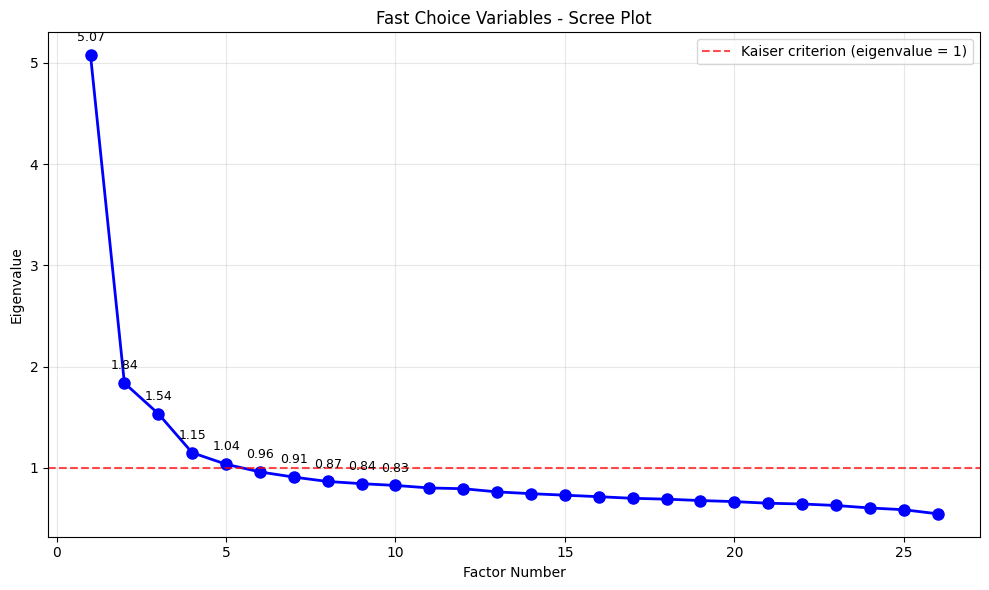

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 11
Factors explaining 70% variance: 15
First 5 factors explain: 40.9% of variance

Using 5 factors for analysis

=== Fast Choice Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 5.075 | 19.5% of total | 47.7% of extracted | 47.7% cumulative
Factor 2: 1.838 | 7.1% of total | 17.3% of extracted | 65.0% cumulative
Factor 3: 1.536 | 5.9% of total | 14.4% of extracted | 79.4% cumulative
Factor 4: 1.150 | 4.4% of total | 10.8% of extracted | 90.3% cumulative
Factor 5: 1.036 | 4.0% of total | 9.7% of extracted | 100.0% cumulative

Factor Loadings (|loading| > 0.4 marked with *):
Variable                                            Factor1   Factor2   Factor3   Factor4   Factor5
--------------------------------------------------------------------------------
* Anxious about change                     -0.012   -0.003    0.023   -0.043    0.254 
* Happy where I am                          0.342    0.336  

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


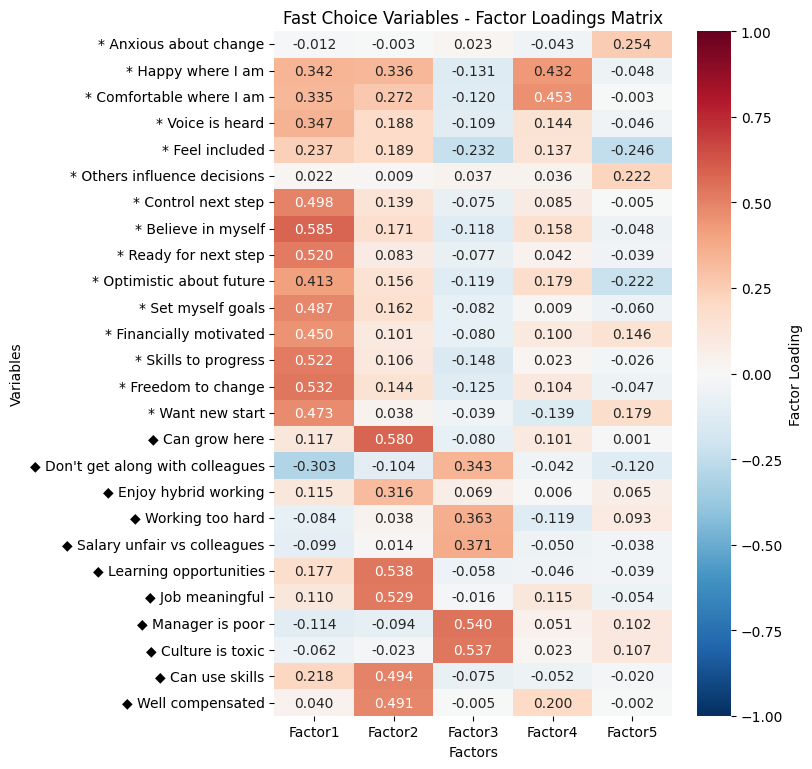


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am                     0.435
* Believe in myself                    0.413
* Comfortable where I am               0.406
◆ Can grow here                        0.366
* Freedom to change                    0.333
◆ Learning opportunities               0.327
◆ Manager is poor                      0.326
◆ Job meaningful                       0.308
* Skills to progress                   0.306
◆ Culture is toxic                     0.304
◆ Can use skills                       0.301
* Optimistic about future              0.291
* Ready for next step                  0.287
◆ Well compensated                     0.283
* Control next step                    0.280
* Want new start                       0.278
* Set myself goals                     0.274
* Financially motivated                0.250
◆ Don't get along with colleagues      0.237
* Feel included

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


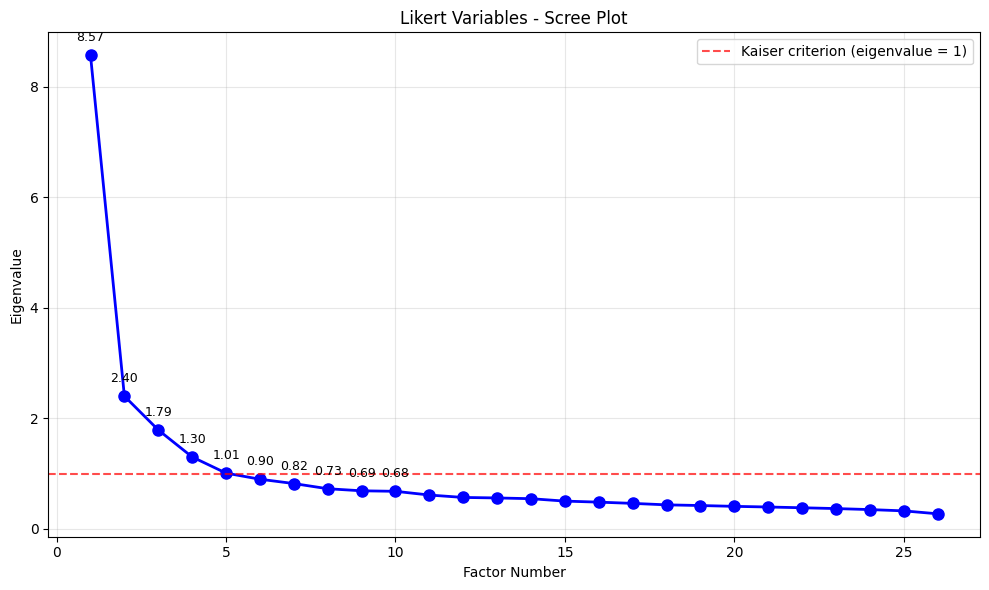

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 6
Factors explaining 70% variance: 9
First 5 factors explain: 58.0% of variance

Using 5 factors for analysis

=== Likert Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 8.570 | 33.0% of total | 56.9% of extracted | 56.9% cumulative
Factor 2: 2.402 | 9.2% of total | 15.9% of extracted | 72.8% cumulative
Factor 3: 1.790 | 6.9% of total | 11.9% of extracted | 84.7% cumulative
Factor 4: 1.302 | 5.0% of total | 8.6% of extracted | 93.3% cumulative
Factor 5: 1.010 | 3.9% of total | 6.7% of extracted | 100.0% cumulative

Factor Loadings (|loading| > 0.4 marked with *):
Variable                                            Factor1   Factor2   Factor3   Factor4   Factor5
--------------------------------------------------------------------------------
* Anxious about change (L)                 -0.074   -0.126    0.093   -0.527*  -0.098 
* Happy where I am (L)                      0.130    0.431*  -0.284 

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


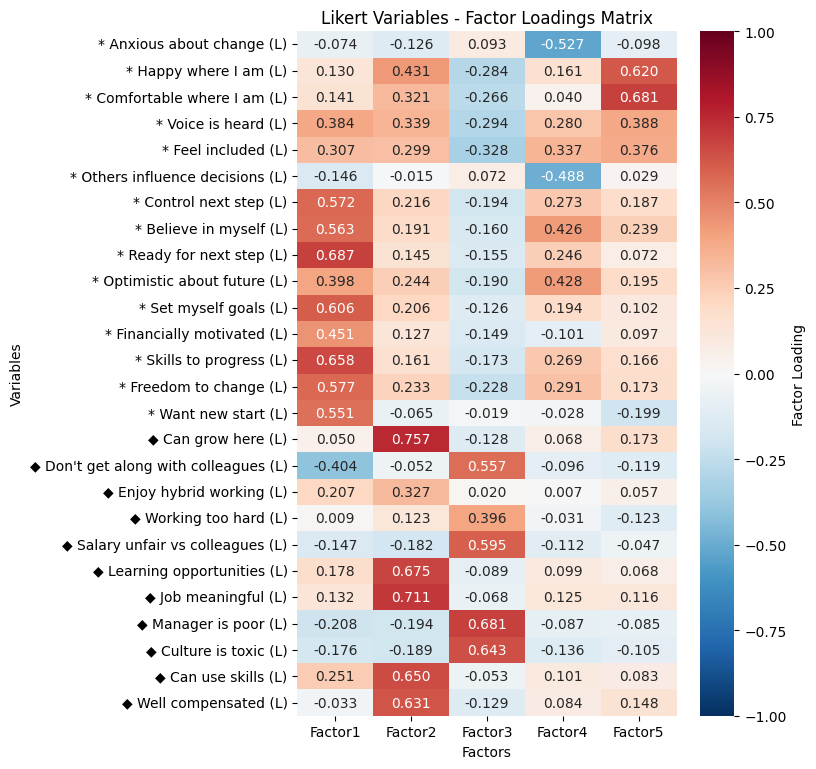


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am (L)                 0.694
* Comfortable where I am (L)           0.659
◆ Can grow here (L)                    0.627
* Believe in myself (L)                0.619
* Skills to progress (L)               0.590
* Ready for next step (L)              0.582
* Voice is heard (L)                   0.578
◆ Manager is poor (L)                  0.559
◆ Job meaningful (L)                   0.556
* Freedom to change (L)                0.553
* Feel included (L)                    0.546
* Control next step (L)                0.521
◆ Learning opportunities (L)           0.510
◆ Culture is toxic (L)                 0.509
◆ Can use skills (L)                   0.505
◆ Don't get along with colleagues...    0.500
* Optimistic about future (L)          0.475
* Set myself goals (L)                 0.474
◆ Well compensated (L)                 0.444
◆ Salary unfai

In [5]:

# Main analysis
print("=" * 80)
print("COMPREHENSIVE FACTOR ANALYSIS")
print("=" * 80)

print("\n" + "="*60)
print("APPROACH 1: BASELINE - FAST CHOICE vs LIKERT SEPARATION")
print("="*60)

# 1. Baseline: Fast Choice vs Likert (existing approach)
results_fast = perform_factor_analysis(data, fast_choice_vars, "Fast Choice Variables")
results_likert = perform_factor_analysis(data, likert_vars, "Likert Variables")



APPROACH 2: EMOTIONAL vs WORKPLACE SEPARATION

Emotional Variables - Sample size after removing missing: 4198
Bartlett's test: Chi-square = 42640.43, p-value = 0.0000
KMO test: 0.944


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


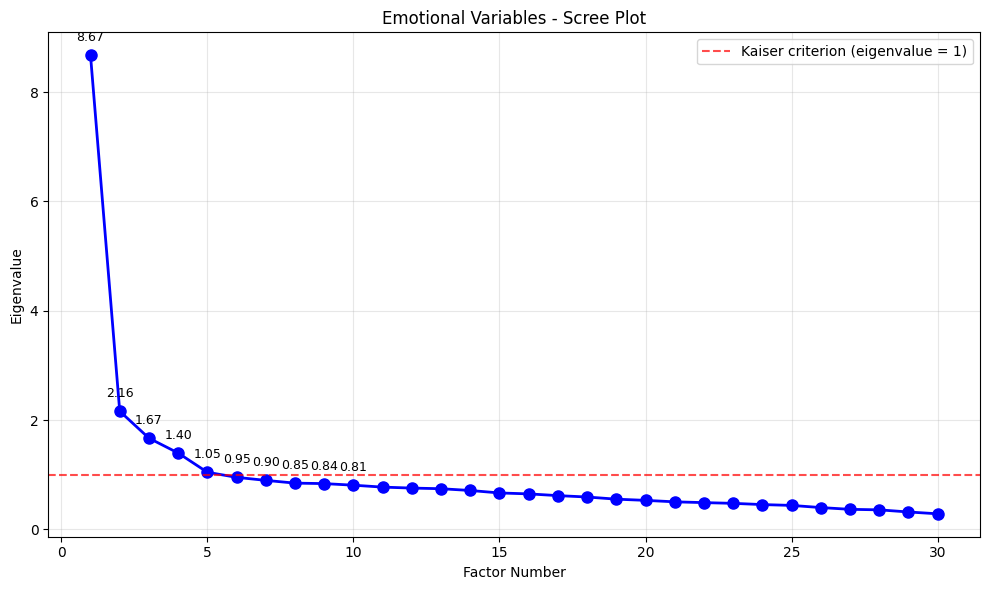

Number of factors (Kaiser criterion): 5
Factors explaining 60% variance: 9
Factors explaining 70% variance: 13
First 5 factors explain: 49.8% of variance

Using 5 factors for analysis

=== Emotional Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 8.672 | 28.9% of total | 58.0% of extracted | 58.0% cumulative
Factor 2: 2.163 | 7.2% of total | 14.5% of extracted | 72.5% cumulative
Factor 3: 1.670 | 5.6% of total | 11.2% of extracted | 83.6% cumulative
Factor 4: 1.398 | 4.7% of total | 9.4% of extracted | 93.0% cumulative
Factor 5: 1.046 | 3.5% of total | 7.0% of extracted | 100.0% cumulative

Factor Loadings (|loading| > 0.4 marked with *):
Variable                                            Factor1   Factor2   Factor3   Factor4   Factor5
--------------------------------------------------------------------------------
* Anxious about change (L)                 -0.186   -0.146   -0.055   -0.703*   0.143 
* Happy where I am (L)                      0.809*   0.097    0.

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


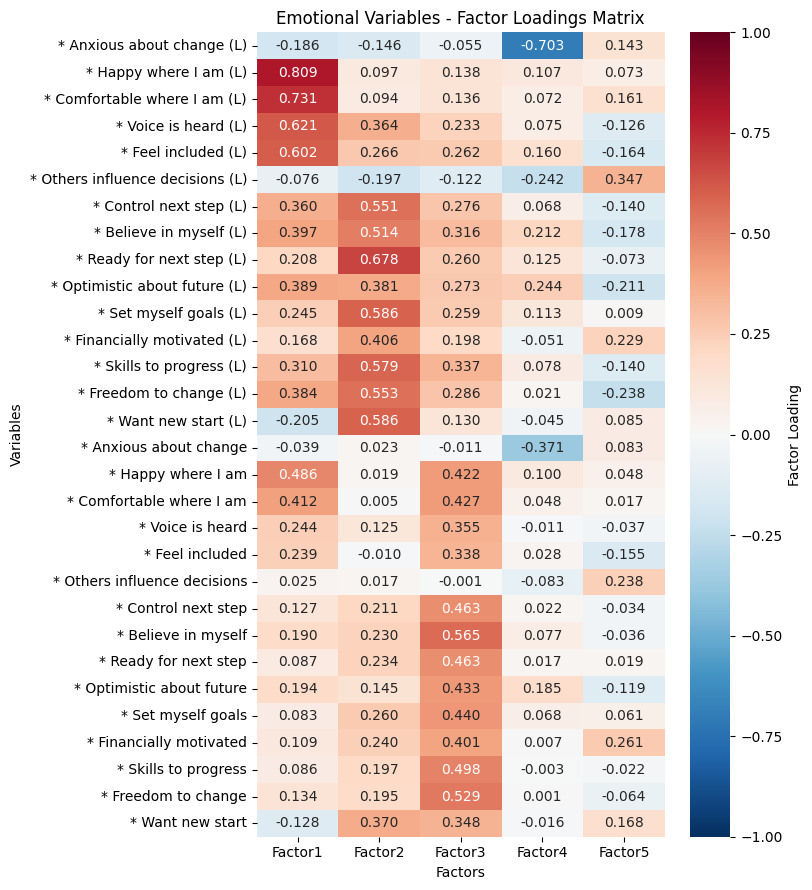


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Happy where I am (L)                 0.700
* Believe in myself (L)                0.599
* Voice is heard (L)                   0.594
* Comfortable where I am (L)           0.593
* Freedom to change (L)                0.592
* Ready for next step (L)              0.591
* Anxious about change (L)             0.574
* Skills to progress (L)               0.571
* Feel included (L)                    0.555
* Control next step (L)                0.533
* Set myself goals (L)                 0.484
* Optimistic about future (L)          0.475
* Happy where I am                     0.427
* Believe in myself                    0.416
* Want new start (L)                   0.412
* Comfortable where I am               0.354
* Freedom to change                    0.340
* Want new start                       0.303
* Financially motivated                0.299
* Optimistic ab

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


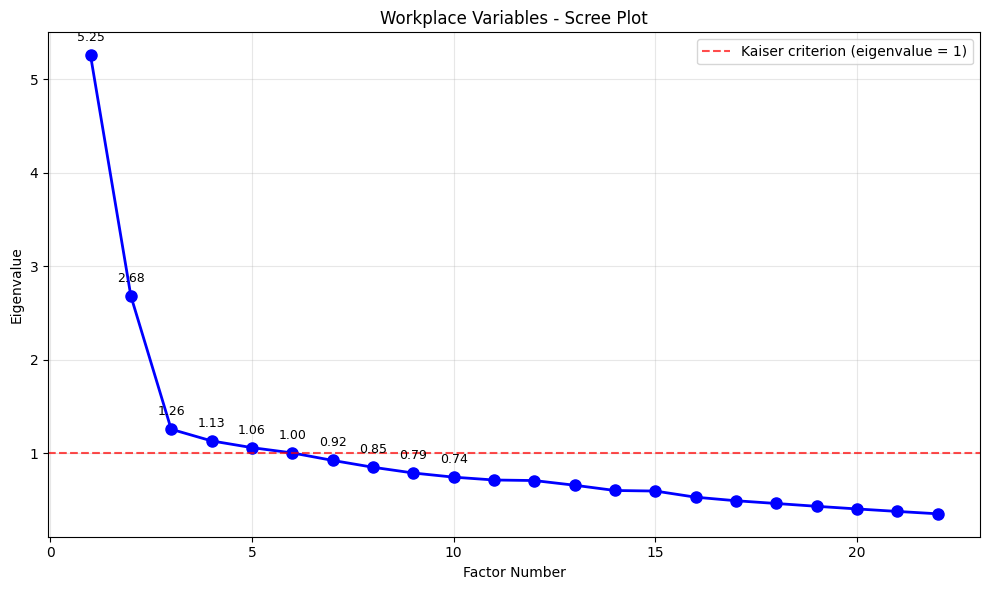

Number of factors (Kaiser criterion): 6
Factors explaining 60% variance: 7
Factors explaining 70% variance: 10
First 5 factors explain: 51.7% of variance

Using 5 factors for analysis

=== Workplace Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 5.254 | 23.9% of total | 46.2% of extracted | 46.2% cumulative
Factor 2: 2.681 | 12.2% of total | 23.6% of extracted | 69.7% cumulative
Factor 3: 1.255 | 5.7% of total | 11.0% of extracted | 80.8% cumulative
Factor 4: 1.131 | 5.1% of total | 9.9% of extracted | 90.7% cumulative
Factor 5: 1.059 | 4.8% of total | 9.3% of extracted | 100.0% cumulative

Factor Loadings (|loading| > 0.4 marked with *):
Variable                                            Factor1   Factor2   Factor3   Factor4   Factor5
--------------------------------------------------------------------------------
◆ Can grow here (L)                         0.723*  -0.073    0.224    0.095    0.095 
◆ Don't get along with colleagues (L)      -0.121    0.640*  -0

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


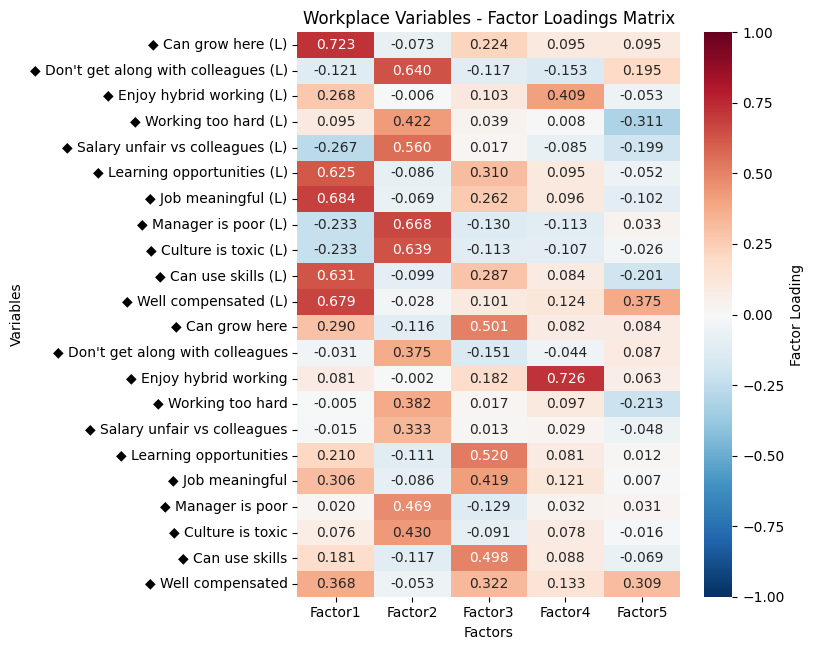


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
◆ Well compensated (L)                 0.628
◆ Can grow here (L)                    0.596
◆ Enjoy hybrid working                 0.571
◆ Job meaningful (L)                   0.561
◆ Can use skills (L)                   0.538
◆ Manager is poor (L)                  0.532
◆ Learning opportunities (L)           0.505
◆ Don't get along with colleagues...    0.500
◆ Culture is toxic (L)                 0.487
◆ Salary unfair vs colleagues (L)      0.432
◆ Can grow here                        0.362
◆ Well compensated                     0.355
◆ Learning opportunities               0.334
◆ Can use skills                       0.306
◆ Job meaningful                       0.291
◆ Working too hard (L)                 0.285
◆ Enjoy hybrid working (L)             0.252
◆ Manager is poor                      0.239
◆ Culture is toxic                     0.205
◆ Working too 

In [6]:

print("\n" + "="*60)
print("APPROACH 2: EMOTIONAL vs WORKPLACE SEPARATION")
print("="*60)

# 2. Emotional vs Workplace separation
results_emotional = perform_factor_analysis(data, emotional_vars, "Emotional Variables")
results_workplace = perform_factor_analysis(data, workplace_vars, "Workplace Variables")



APPROACH 3: COMBINED ALL SURVEY VARIABLES

All Survey Variables Combined - Sample size after removing missing: 4193
Bartlett's test: Chi-square = 72646.08, p-value = 0.0000
KMO test: 0.949


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


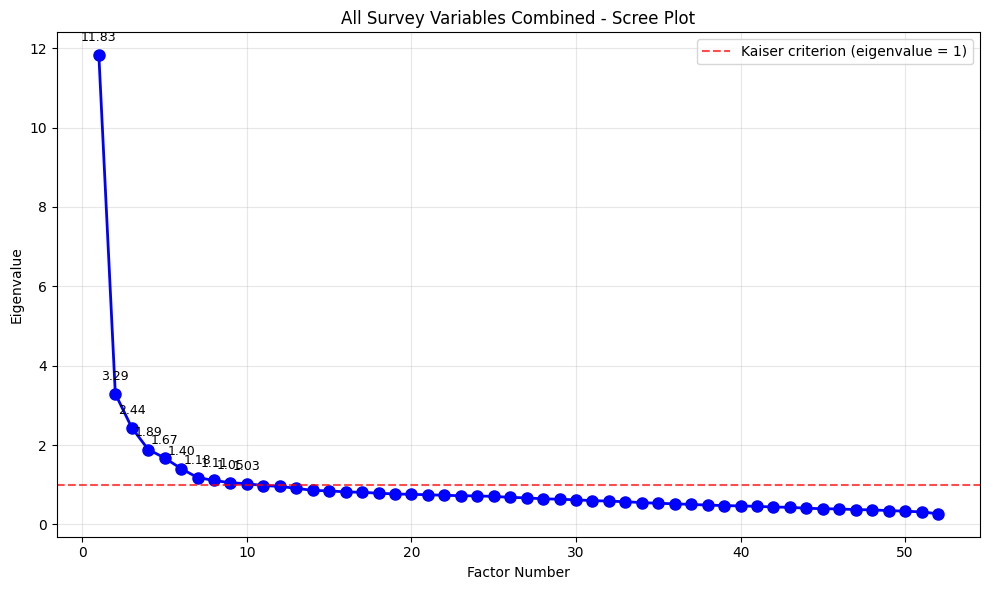

Number of factors (Kaiser criterion): 10
Factors explaining 60% variance: 15
Factors explaining 70% variance: 22
First 5 factors explain: 40.6% of variance

Using 5 factors for analysis


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== All Survey Variables Combined RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 11.825 | 22.7% of total | 56.0% of extracted | 56.0% cumulative
Factor 2: 3.293 | 6.3% of total | 15.6% of extracted | 71.6% cumulative
Factor 3: 2.436 | 4.7% of total | 11.5% of extracted | 83.1% cumulative
Factor 4: 1.887 | 3.6% of total | 8.9% of extracted | 92.1% cumulative
Factor 5: 1.674 | 3.2% of total | 7.9% of extracted | 100.0% cumulative

Factor Loadings (|loading| > 0.4 marked with *):
Variable                                            Factor1   Factor2   Factor3   Factor4   Factor5
--------------------------------------------------------------------------------
* Anxious about change                     -0.003   -0.003    0.036    0.014   -0.268 
* Happy where I am                          0.362    0.434*  -0.039   -0.186    0.237 
* Comfortable where I am                    0.305    0.428*  -0.039   -0.160    0.191 
* Voice is heard                            0.181    0.356    0

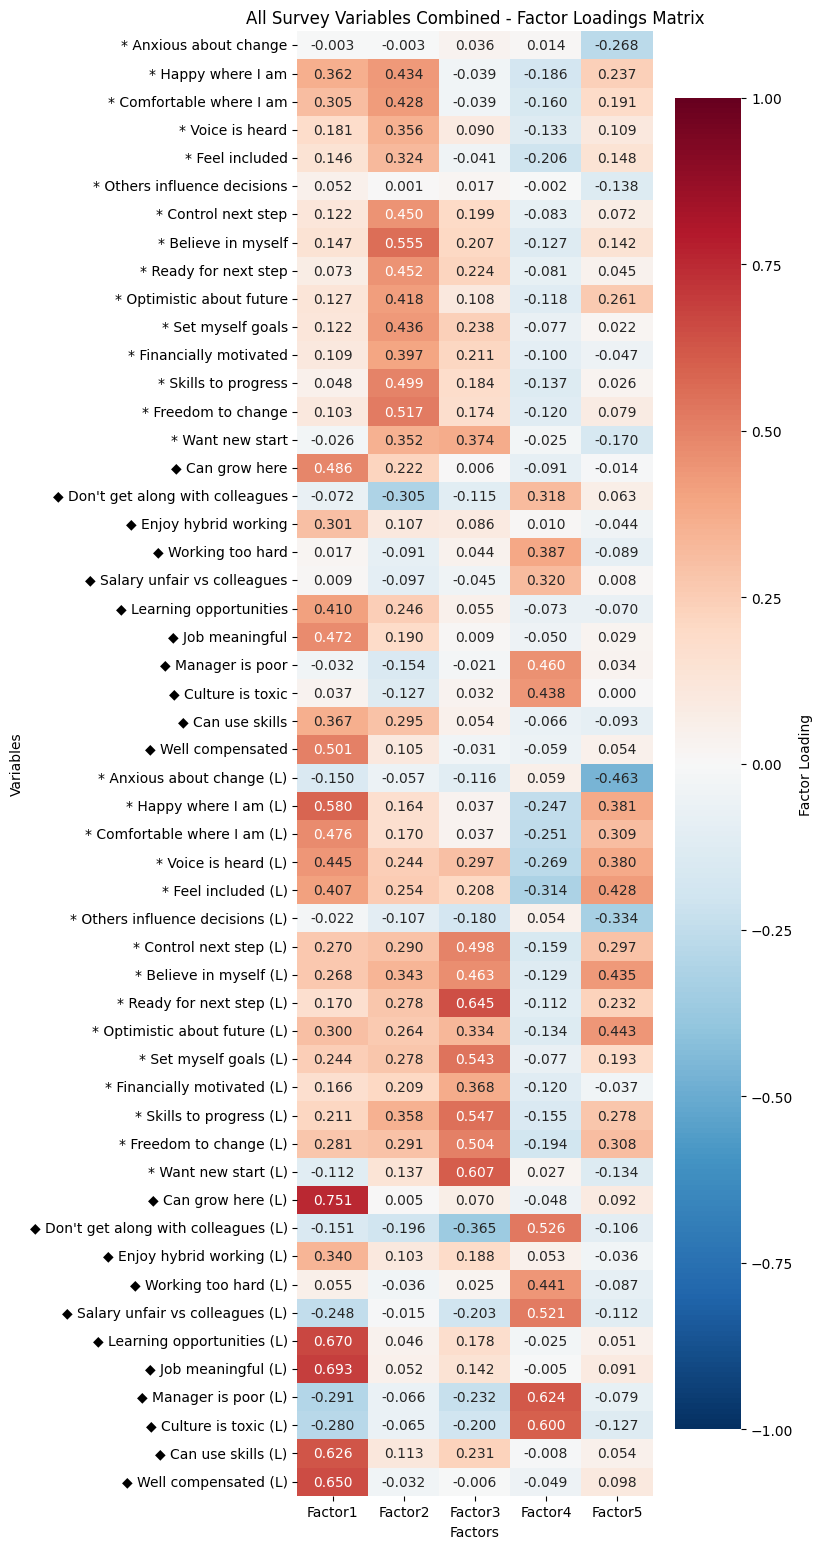


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
* Believe in myself (L)                0.610
* Ready for next step (L)              0.589
◆ Can grow here (L)                    0.579
* Skills to progress (L)               0.573
* Happy where I am (L)                 0.571
* Voice is heard (L)                   0.563
* Feel included (L)                    0.555
* Freedom to change (L)                0.550
◆ Manager is poor (L)                  0.539
* Control next step (L)                0.518
◆ Job meaningful (L)                   0.511
◆ Culture is toxic (L)                 0.499
◆ Learning opportunities (L)           0.486
* Optimistic about future (L)          0.485
◆ Don't get along with colleagues...    0.482
* Set myself goals (L)                 0.475
◆ Can use skills (L)                   0.461
◆ Well compensated (L)                 0.436
* Want new start (L)                   0.418
* Comfortable 

In [7]:

print("\n" + "="*60)
print("APPROACH 3: COMBINED ALL SURVEY VARIABLES")
print("="*60)

# 3. Combined all survey variables
results_combined = perform_factor_analysis(data, all_survey_vars, "All Survey Variables Combined")



APPROACH 4: PERSONALITY VARIABLES ONLY

Personality Variables - Sample size after removing missing: 4211
Bartlett's test: Chi-square = 12157.84, p-value = 0.0000
KMO test: 0.776


c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


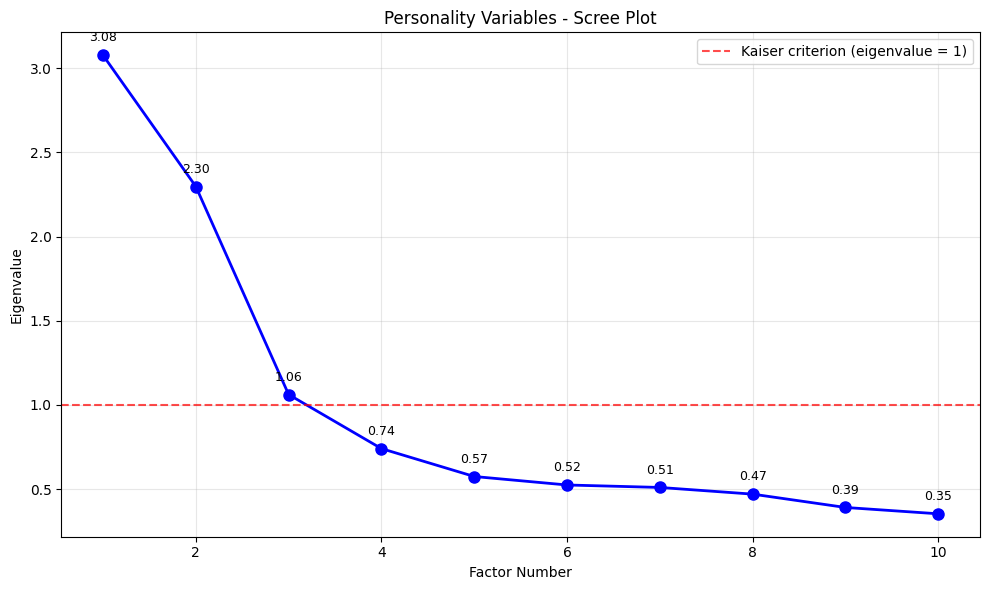

Number of factors (Kaiser criterion): 3
Factors explaining 60% variance: 3
Factors explaining 70% variance: 4
First 5 factors explain: 77.5% of variance

Using 3 factors for analysis

=== Personality Variables RESULTS ===

Eigenvalues and Variance Explained:
Factor 1: 3.077 | 30.8% of total | 47.8% of extracted | 47.8% cumulative
Factor 2: 2.297 | 23.0% of total | 35.7% of extracted | 83.5% cumulative
Factor 3: 1.062 | 10.6% of total | 16.5% of extracted | 100.0% cumulative

Factor Loadings (|loading| > 0.4 marked with *):
Variable                                            Factor1   Factor2   Factor3
--------------------------------------------------------------------------------
Extraverted Enthusiastic                    0.609*   0.097   -0.227 
Critical Quarrelsome                       -0.035    0.721*  -0.032 
Dependable Self-Disciplined                 0.657*  -0.158    0.172 
Anxious Easily Upset                       -0.113    0.683*   0.080 
Open To New Experiences Complex   

c:\Users\rhrou\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


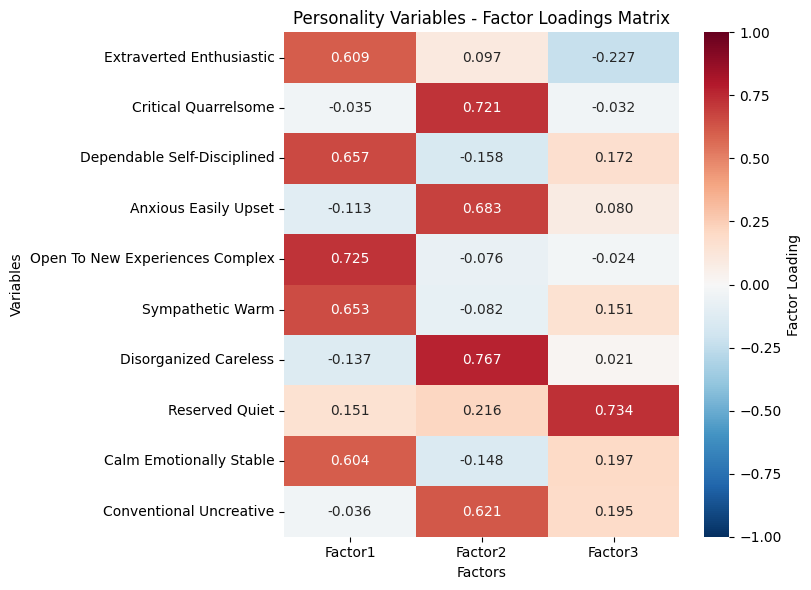


Communalities (sorted by value):
Variable                            Communality
-----------------------------------------------
Reserved Quiet                         0.609
Disorganized Careless                  0.607
Open To New Experiences Complex        0.531
Critical Quarrelsome                   0.523
Dependable Self-Disciplined            0.486
Anxious Easily Upset                   0.485
Sympathetic Warm                       0.456
Extraverted Enthusiastic               0.432
Calm Emotionally Stable                0.426
Conventional Uncreative                0.425

✅ All variables have adequate communalities (≥ 0.3)


In [8]:

print("\n" + "="*60)
print("APPROACH 4: PERSONALITY VARIABLES ONLY")  
print("="*60)

# 4. Personality variables only
# Create personality name mapping
personality_names = {}
for col in personality_vars:
    clean_name = col.replace('pers_', '').replace('_', ' ').title()
    personality_names[col] = clean_name

# Update all_names to include personality variables for this analysis
all_names_with_pers = {**all_names, **personality_names}

# Temporarily update the function's naming dictionary
original_all_names = all_names.copy()
all_names.update(personality_names)

results_personality = perform_factor_analysis(data, personality_vars, "Personality Variables")

# Restore original naming
all_names = original_all_names


In [9]:

print("\n" + "="*80)
print("SUMMARY OF ALL APPROACHES")
print("="*80)

approaches = [
    ("Fast Choice Variables", results_fast),
    ("Likert Variables", results_likert), 
    ("Emotional Variables", results_emotional),
    ("Workplace Variables", results_workplace),
    ("All Survey Variables", results_combined),
    ("Personality Variables", results_personality)
]

print(f"{'Approach':<25} {'N Variables':<12} {'N Factors':<10} {'Explained Var':<15}")
print("-" * 65)

for name, results in approaches:
    n_vars = len(results['loadings'])
    n_factors = results['n_factors']
    total_explained = sum(results['eigenvalues']) / n_vars * 100
    print(f"{name:<25} {n_vars:<12} {n_factors:<10} {total_explained:<13.1f}%")




SUMMARY OF ALL APPROACHES
Approach                  N Variables  N Factors  Explained Var  
-----------------------------------------------------------------
Fast Choice Variables     26           5          40.9         %
Likert Variables          26           5          58.0         %
Emotional Variables       30           5          49.8         %
Workplace Variables       22           5          51.7         %
All Survey Variables      52           5          40.6         %
Personality Variables     10           3          64.4         %


### Save and determine whether to add any factor scores to dataset

Come back to this later if it's deemed necessary in further analyses

In [10]:

# Save all heatmaps to results/factor_analysis folder
import os

# Create directory structure
os.makedirs("../results/factor_analysis", exist_ok=True)

print("\n" + "="*60)
print("SAVING FACTOR LOADING HEATMAPS")
print("="*60)

# Function to recreate and save heatmaps
def save_factor_heatmap(results, var_list, title, filename):
    """Recreate and save factor loading heatmap"""
    
    factor_cols = [f'Factor{i+1}' for i in range(results['n_factors'])]
    loadings_matrix = results['loadings'][factor_cols]
    
    plt.figure(figsize=(8, max(6, len(var_list) * 0.3)))
    sns.heatmap(loadings_matrix, 
                annot=True, 
                fmt='.3f',
                cmap='RdBu_r', 
                center=0,
                vmin=-1, 
                vmax=1,
                cbar_kws={'label': 'Factor Loading'},
                yticklabels=[all_names.get(var, var) for var in var_list])
    
    plt.title(f'{title} - Factor Loadings Matrix')
    plt.xlabel('Factors')
    plt.ylabel('Variables')
    plt.tight_layout()
    
    # Save the figure
    filepath = f"../results/factor_analysis/{filename}.png"
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()  # Close to free memory
    
    print(f"✅ Saved: {filepath}")

# Save all heatmaps
save_factor_heatmap(results_fast, fast_choice_vars, "Fast Choice Variables", "fast_choice_loadings")
save_factor_heatmap(results_likert, likert_vars, "Likert Variables", "likert_loadings")
save_factor_heatmap(results_emotional, emotional_vars, "Emotional Variables", "emotional_loadings")
save_factor_heatmap(results_workplace, workplace_vars, "Workplace Variables", "workplace_loadings")
save_factor_heatmap(results_combined, all_survey_vars, "All Survey Variables Combined", "combined_loadings")

# For personality variables, temporarily update naming
all_names_temp = all_names.copy()
personality_names = {}
for col in personality_vars:
    clean_name = col.replace('pers_', '').replace('_', ' ').title()
    personality_names[col] = clean_name
all_names.update(personality_names)

save_factor_heatmap(results_personality, personality_vars, "Personality Variables", "personality_loadings")

# Restore original naming
all_names = all_names_temp

print(f"\n✅ All factor loading heatmaps saved to: ../results/factor_analysis/")
print("Files created:")
print("  - fast_choice_loadings.png")
print("  - likert_loadings.png") 
print("  - emotional_loadings.png")
print("  - workplace_loadings.png")
print("  - combined_loadings.png")
print("  - personality_loadings.png")



SAVING FACTOR LOADING HEATMAPS
✅ Saved: ../results/factor_analysis/fast_choice_loadings.png
✅ Saved: ../results/factor_analysis/likert_loadings.png
✅ Saved: ../results/factor_analysis/emotional_loadings.png
✅ Saved: ../results/factor_analysis/workplace_loadings.png
✅ Saved: ../results/factor_analysis/combined_loadings.png
✅ Saved: ../results/factor_analysis/personality_loadings.png

✅ All factor loading heatmaps saved to: ../results/factor_analysis/
Files created:
  - fast_choice_loadings.png
  - likert_loadings.png
  - emotional_loadings.png
  - workplace_loadings.png
  - combined_loadings.png
  - personality_loadings.png


In [11]:

print("\n" + "="*60)
print("ADDING FACTOR SCORES TO DATASET")
print("="*60)

# Toggle this to add factor scores to your dataset
ADD_FACTOR_SCORES = False  # Change to True to add factor scores

if ADD_FACTOR_SCORES:
    # Choose which approach (change this line to switch approaches)
    approach = "combined"  # Options: "fast", "likert", "emotional", "workplace", "combined"
    
    # Map approach to results
    approach_map = {
        "fast": (results_fast, fast_choice_vars),
        "likert": (results_likert, likert_vars), 
        "emotional": (results_emotional, emotional_vars),
        "workplace": (results_workplace, workplace_vars),
        "combined": (results_combined, all_survey_vars)
    }
    
    results_dict, var_list = approach_map[approach]
    
    # Get clean data and standardize
    clean_data = data[var_list].dropna()
    scaler = StandardScaler() 
    standardized_data = scaler.fit_transform(clean_data)
    
    # Calculate factor scores
    factor_scores = results_dict['factor_analyzer'].transform(standardized_data)
    
    # Add to dataset
    for i in range(results_dict['n_factors']):
        factor_col = f"{approach}_factor_{i+1}"
        data[factor_col] = np.nan  # Initialize with NaN
        data.loc[clean_data.index, factor_col] = factor_scores[:, i]
    
    print(f"✅ Added {results_dict['n_factors']} factor scores using '{approach}' approach")
    print(f"New columns: {[f'{approach}_factor_{i+1}' for i in range(results_dict['n_factors'])]}")
    
    # Save updated dataset
    data.to_pickle("../data/survey_data_with_factors.pkl")
    print("✅ Saved updated dataset to ../data/survey_data_with_factors.pkl")
    
else:
    print("Factor scores not added. Set ADD_FACTOR_SCORES = True to add them.")
    print("Then choose your approach by changing the 'approach' variable.")


ADDING FACTOR SCORES TO DATASET
Factor scores not added. Set ADD_FACTOR_SCORES = True to add them.
Then choose your approach by changing the 'approach' variable.
